# Creative extension

__Paper:__ Housing, Health, and Happiness

__Data:__ National Survey of America's Families, 2002

__Aim:__
1) Which living outcome do housing conditions affect the most (education, health or happiness)?

2) Is there a correlation between precarious housing and health (both physical and mental) status?

3) In what ways do living conditions affect children scholarship (if they do) ? Which age group is most impacted ?


## Data pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from math import exp, log
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# Load data

data_folder = './data/'
# Focal Child Data
fc = pd.read_stata(data_folder+'DS0001/04582-0001-Data.dta',convert_categoricals=False)
# Household Data
hh = pd.read_stata(data_folder+'DS0006/04582-0006-Data.dta',convert_categoricals=False)

In [3]:
# Variables of interest in child and hh datasets 
person_id = ['PERSID','PERSTYPE','RESPID','UCPSID','SEX','UAGE','SITE','STATE','UREGION','TYPEINT','HHID']
household_id_hh = ['HHID']
#education = ['CCHGSC','CSUEXP','CATTSC','CSKIPSC','CGETBY','CHMWK','CINTSC','CWRKSC','UENG','UENGNEG','UENGPOS']
education = ['UENG','UENGNEG','UENGPOS','NLESSONS']
#family = ['GHMAD','GSELFHR','UFAMSTR','UMH2','UMHIGDEG']
family = ['UFAMSTR','UMH2','UMHIGDEG','UAGG']
family_hh = ['CHLD0_5','CHLD6_17','UHHCOUNT']
income = ['U_SOCPOV']
income_hh = ['QSC5']
housing_hh = ['MNBEDRMS','MOWNRENT'] #'OVERCROWDING' added later on
mental_health = ['UBPIA','UBPIANEG','UBPIAPOS','UBPIB','UBPIBNEG','UBPIBPOS']
health = ['BDISBL','BHLTHN','FDOCT','FWHMED','FWHYMED','FDENT','FWELLV','UCNGHL']
activities = ['NOUTING','NSPORTS','UOUTNEG','UOUTPOS','UACT','UACTNEG','UACTPOS']
programs = ['GCENTR','CSPECED','CAGRAD','GHEADS','KAPPMED','SSHELP']
programs_hh = ['MPUBHOUS']
eco = ['CJOB','UHINS4'] #NB CJOB only for fc3

# Add a variable 'overcrowding' and replace inf by -1
hh['OVERCROWDING'] = hh['UHHCOUNT'] / hh['MNBEDRMS']
housing_hh.append('OVERCROWDING')
hh['OVERCROWDING'] = hh['OVERCROWDING'].apply(lambda x : -1 if (x == np.inf or x < 0) else x)

# Reduce dataframes to variables of interest
fc = fc[person_id + education + family + income + mental_health + health + activities + programs + eco]
hh = hh[household_id_hh + family_hh + income_hh + housing_hh + programs_hh]

In [4]:
# Merge dataframes using the household ID number, 
# inner merge keeps only households that are linked to a focal child subject
child = pd.merge(fc, hh, left_on = 'HHID', right_on = 'HHID', how='inner')

# NaNs handling : replace all the missing values by -1
child.replace([-7,-8,-9],-1,inplace=True)

# Make the SEX variable binary with F=1 and M=0
child['SEX'].replace(to_replace=dict(F=1, M=0),inplace=True)
# Make the CJOB variable binary with Yes=1 and No=0
child['CJOB'].replace(2,0,inplace=True)
# Make the NLESSONS variable binary with Yes=1 and No=0
child['NLESSONS'].replace(2,0,inplace=True)

# Preview of child dataframe
child.head()

,PERSID,PERSTYPE,RESPID,UCPSID,SEX,UAGE,SITE,STATE,UREGION,TYPEINT,...,CJOB,UHINS4,CHLD0_5,CHLD6_17,UHHCOUNT,QSC5,MNBEDRMS,MOWNRENT,OVERCROWDING,MPUBHOUS
0,5561612801,1,5561612803,5561612800,1,3,15,WI,2,A1,...,-1,2,2,0,3,1,4,1,0.75,-1
1,5470400001,2,5470400003,5470400000,0,14,15,WI,2,A1,...,0,1,0,2,3,2,2,2,1.50,-1
2,5787427204,2,5787427205,5787427200,1,9,15,WI,2,A1,...,-1,2,0,4,6,1,3,2,2.00,2
3,5410681601,1,5410681604,5410681600,0,4,15,WI,2,A1,...,-1,2,3,0,5,1,2,2,2.50,2
4,5051721601,2,5051721605,5051721600,1,17,15,WI,2,A1,...,1,2,0,4,5,1,4,2,1.25,1


In [5]:
# Divide child data in 4 dfs based on age groups

# Keep data of focal children from age 0 to 17 only
child = child.loc[child['PERSTYPE'].isin([1,2])]

# are there young children (0-5yo) in household?
child.loc[:,'bool0_5'] = child['CHLD0_5'].apply(lambda x : 0 if x == 0 else 1)

# FC1 : focal child, aged 0-5
fc1 = child.copy()[child['PERSTYPE']==1]

# FC23 : focal child, aged 6-17
fc23 = child.copy()[child['PERSTYPE']==2]

# FC2 : focal child, aged 6-11
fc2 = child.copy()[(child['PERSTYPE']==2) & (child['UAGE'] < 12)]

# FC3 : focal child, aged 12-17
fc3 = child.copy()[(child['PERSTYPE']==2) & (child['UAGE'] >= 12)]

In [6]:
print(f'Shapes of dataframes:\nfc1: {fc1.shape}\nfc2: {fc2.shape}\nfc3:{fc3.shape}\nfc23: {fc23.shape}')
print((fc1.shape[0] + fc2.shape[0] + fc3.shape[0]) == child.shape[0]) #test to see if all children are counted

Shapes of dataframes:
fc1: (12268, 58)
fc2: (10925, 58)
fc3:(11087, 58)
fc23: (22012, 58)
True


## Propensity score attempt

__Living conditions indicator :__

In [7]:
# returns a dataframe where the rows of the given 'df' containing NaN values for either the 'outcome'
# or any of the 'predictors' have been removed
def df_NN(df,outcome,predictors):
    if len(predictors) <= 1:
        bools = (df[predictors[0]] != -1)
    else:
        bools = df[predictors].isin([-1]).any(axis=1)==False
    
    return df.loc[(df[outcome] != -1) & (bools)]

In [8]:
# Variables used for precarity indicator (economics and relationship with family)
# NB CHOICE OF WORDS : PRECARITY NOT VERY ACCURATE
prec = ['U_SOCPOV','OVERCROWDING','MOWNRENT','UHINS4','UAGG','UFAMSTR']
#prec3 = prec + ['CJOB']

# IL FAUDRA DECIDER DE COMMENT GERER LES NANS SUR CES VALEURS POUR DEFINIR L'INDEX

df_prec_2 = df_NN(fc2,'PERSID',prec)
#df_prec_3 = df_NN(fc3,'PERSID',prec3)

In [9]:
# Living conditions indicator
negative = ['OVERCROWDING','MOWNRENT','UHINS4']
#negative3 = negative + ['CJOB']
positive = ['U_SOCPOV','UAGG','UFAMSTR']
    
# Normalize all the variables and sign them -> WE CAN CHOOSE WEIGHTS LATER TO TUNE THE INDEX
# NB performs column-wise automatically
norm_prec_2 =(df_prec_2[prec]-df_prec_2[prec].min())/(df_prec_2[prec].max()-df_prec_2[prec].min())
#norm_prec_3 =(df_prec_3[prec3]-df_prec_3[prec3].min())/(df_prec_3[prec3].max()-df_prec_3[prec3].min())
norm_prec_2.loc[:,negative] *= -1
#norm_prec_3.loc[:,negative3] *= -1

# Compute living conditions indicator
norm_prec_2.loc[:,'living_ind'] = norm_prec_2.sum(axis=1)
#norm_prec_3.loc[:,'living_ind'] = norm_prec_3.sum(axis=1)

In [10]:
# Choose a threshold to consider a household 'precarious' or not -> ADAPT (j'ai juste pris zero en mode random)
norm_prec_2.loc[:,'precarious'] = norm_prec_2['living_ind'].apply(lambda x : 1 if x < 1 else 0)
#norm_prec_3.loc[:,'precarious'] = norm_prec_3['living_ind'].apply(lambda x : 1 if x < 1 else 0)

# Merge this new column with whole df without NaNs
fc2_prec = pd.merge(fc2, norm_prec_2['precarious'], left_index=True, right_index=True, how='inner')
#fc3_prec = pd.merge(fc3, norm_prec_3['precarious'], left_index=True, right_index=True, how='inner')

In [11]:
fc2_prec.head()

,PERSID,PERSTYPE,RESPID,UCPSID,SEX,UAGE,SITE,STATE,UREGION,TYPEINT,...,CHLD0_5,CHLD6_17,UHHCOUNT,QSC5,MNBEDRMS,MOWNRENT,OVERCROWDING,MPUBHOUS,bool0_5,precarious
2,5787427204,2,5787427205,5787427200,1,9,15,WI,2,A1,...,0,4,6,1,3,2,2.000000,2,0,1
6,5353539201,2,5353539204,5353539200,1,11,15,WI,2,A1,...,2,1,9,2,4,2,2.250000,2,1,1
13,5442400001,2,5442400007,5442400000,0,11,15,WI,2,A1,...,3,3,8,1,3,2,2.666667,2,1,1
21,5851446401,2,5851446402,5851446400,0,7,15,WI,2,A1,...,0,1,2,1,2,2,1.000000,2,0,1
22,5047936001,2,5047936005,5047936000,1,8,15,WI,2,A1,...,3,1,5,1,3,2,1.666667,2,1,1


**PS with `bool0_5` as a treatment**

In [12]:
# je retrouve exclusivement les rows avec PERSTYPE = 2, surement une variable que je sélectionne qui était seulement demandées aux 6-17

In [13]:
# logistic regression for CHLD0_5
predictors= ['SEX','UREGION','UFAMSTR','UMH2','UMHIGDEG','UAGG','UHHCOUNT','U_SOCPOV','MNBEDRMS','MOWNRENT','OVERCROWDING','BDISBL','BHLTHN','UHINS4']
df_05 = df_NN(child,'bool0_5',predictors)

log_model_1 = 'bool0_5 ~ SEX + UREGION + UFAMSTR + UMH2 + UMHIGDEG + UAGG \
+ UHHCOUNT + U_SOCPOV + MNBEDRMS + MOWNRENT + OVERCROWDING + BDISBL + BHLTHN + UHINS4'

log1 = smf.logit(formula=log_model_1, data=df_05)
res1 = log1.fit()

Optimization terminated successfully.
         Current function value: 0.623071
         Iterations 6


In [14]:
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                bool0_5   No. Observations:                33455
Model:                          Logit   Df Residuals:                    33438
Method:                           MLE   Df Model:                           16
Date:                Sat, 05 Dec 2020   Pseudo R-squ.:                 0.09695
Time:                        00:26:15   Log-Likelihood:                -20845.
converged:                       True   LL-Null:                       -23083.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -3.5015      0.178    -19.722      0.000      -3.849      -3.153
UREGION[T.2]     0.0088      0.034      0.263      0.793      -0.057       0.075
UREGION[T.3]    -0.0149      0.034     -0.431      0.667      -0.082       0.053
UREGION[T.4]     0.0041      0.035      0.115      0.909      -0.065       0.073
SEX             -0.0192      0.024     -0.814      0.416      -0.065       0.027
UFAMSTR          0.2322      0.014     16.819      0.000       0.205       0.259
UMH2             0.0042      0.001      4.211      0.000       0.002       0.006
UMHIGDEG         0.0089      0.006      1.380      0.168      -0.004       0.021
UAGG             0.0079      0.007      1.149      0.251      -0.006       0.021
UHHCOUNT         0.3908      0.021     18.222      0.000       0.349       0.433
U_SOCPOV        -0.2016      0.013    -16.125      0.000      -0.226      -0.177
MNBEDRMS        -0.1764      0.029     -6.003      0.000      -0.234      -0.119
MOWNRENT         0.3442      0.027     12.552      0.000       0.290       0.398
OVERCROWDING     0.3057      0.056      5.461      0.000       0.196       0.415
BDISBL           0.6755      0.042     16.206      0.000       0.594       0.757
BHLTHN          -0.0945      0.014     -6.558      0.000      -0.123      -0.066
UHINS4          -0.0348      0.015     -2.401      0.016      -0.063      -0.006
================================================================================
"""

In [15]:
pred1 = res1.predict(df_05)
diff1 = (pred1 - df_05['bool0_5'])
df_05.loc[:,'PS'] = pred1
print('RES1 :  mean error : '+ str(diff1.mean())+',  std : '+ str(diff1.std()))

RES1 :  mean error : 9.474478359900827e-18,  std : 0.46588218765615036


C:\Users\alanh\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\alanh\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


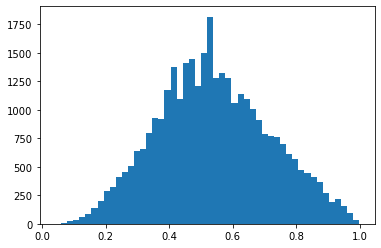

In [16]:
#relativement homogène
plt.hist(pred1,bins=50)
plt.show()

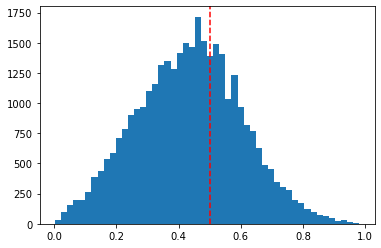

In [17]:
plt.hist(abs(diff1),bins=50)
plt.axvline(0.5,color='r',linestyle='--')
plt.show()

#### without matching

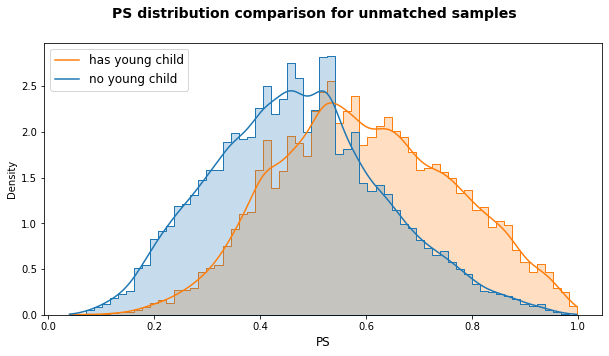

In [18]:
# Plot PS for unmatched groups
fig = plt.figure(figsize=(10,5))
sns.histplot(data=df_05, x="PS", hue='bool0_5', kde=True, element='step', stat='density',
             common_norm=False)
plt.xlabel('PS', fontsize=12)
plt.suptitle('PS distribution comparison for unmatched samples', fontsize=14, fontweight='bold')
plt.legend(['has young child','no young child'], loc='upper left', fontsize = 12)
plt.show()

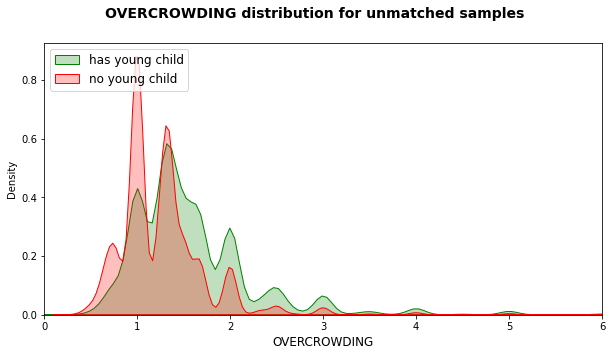

In [19]:
# Plot a seemingly unrelated variable (here OVERCROWDING) for unmatched groups
var = 'OVERCROWDING'
fig = plt.figure(figsize=(10,5))
sns.kdeplot(data=df_05, x=var, hue='bool0_5', palette=['r','g'], shade=True)
plt.xlim(0, 6)
plt.xlabel(var, fontsize=12)
plt.suptitle(var+' distribution for unmatched samples', fontsize=14, fontweight='bold')
plt.legend(['has young child','no young child'], loc='upper left', fontsize = 12)
plt.show()

In [20]:
umh = df_05.groupby('bool0_5').mean()
print('Diff of mean = ' +str(umh['UMH2'][1] - umh['UMH2'][0]))

Diff of mean = 0.6549775806682163


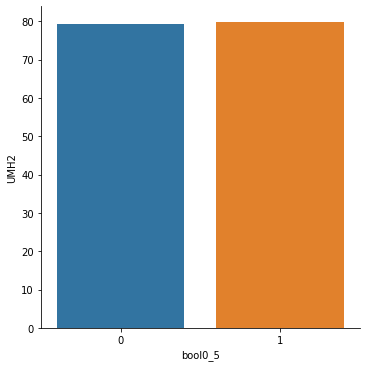

In [21]:
# not huge difference of about 0.33 -> could finish the conclusion by making bootstrap interval -> probably significant
sns.catplot(data=umh.reset_index(),x='bool0_5',y='UMH2',kind='bar')

#### with matching

In [22]:
# Performs caliper matching with caliper width 'epsilon' between treated subjects and non-treated subjects
# returns two lists with indices of matched pairs in 'treatment' and 'control' dataframes
def caliper_matching (treatment, control, epsilon) :
#    matched_pairs = []
    
    # List of control index
    idx = []
    for k in range(control.shape[0]):
        idx.append(k)
    
    # Lists of indices of treated and non-treated matched subjects
    matched_treatment_indices = []
    matched_control_indices = []
    # 1-to-1 matching
    for i in range(treatment.shape[0]) :
        for j in idx :
            diff = abs(control.loc[j,'PS'] - treatment.loc[i,'PS'])
            if diff < epsilon :
                matched_treatment_indices.append(i)
                matched_control_indices.append(j)
                idx.remove(j)
                break
    
    return matched_treatment_indices, matched_control_indices

In [23]:
trtm0_5 = df_05[df_05.bool0_5 == 1].sample(frac=1).reset_index(drop=True)
ctrl0_5 = df_05[df_05.bool0_5 == 0].sample(frac=1).reset_index(drop=True)

# Perform matching between treated and non-treated samples
epsilon=0.05
tr_match_idx, ctl_match_idx = caliper_matching(trtm0_5,ctrl0_5,epsilon)

print(f'Number of treated subjects (children) : {trtm0_5.shape[0]} \n\
Number of control subjects (no children) : {ctrl0_5.shape[0]} \n\
Number of matched pairs : {len(tr_match_idx)}')

Number of treated subjects (children) : 18061 
Number of control subjects (no children) : 15394 
Number of matched pairs : 13496


In [24]:
matched0_5 = trtm0_5.loc[tr_match_idx,:].append(ctrl0_5.loc[ctl_match_idx,:])

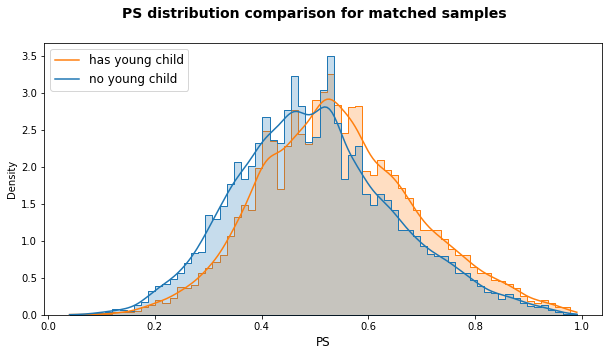

In [25]:
# Plot PS for matched groups
fig = plt.figure(figsize=(10,5))
sns.histplot(data=matched0_5, x="PS", hue='bool0_5', kde=True, element='step', stat='density',
             common_norm=False)
plt.xlabel('PS', fontsize=12)
plt.suptitle('PS distribution comparison for matched samples', fontsize=14, fontweight='bold')
plt.legend(['has young child','no young child'], loc='upper left', fontsize = 12)
plt.show()

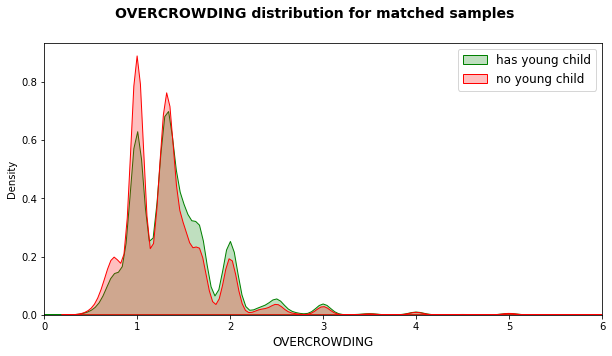

In [26]:
# Plot a seemingly unrelated variable (here OVERCROWDING) for matched groups
var = 'OVERCROWDING'
fig = plt.figure(figsize=(10,5))
sns.kdeplot(data=matched0_5, x=var, hue='bool0_5', palette=['r','g'], shade=True)
plt.xlim(0, 6)
plt.xlabel(var, fontsize=12)
plt.suptitle(var+' distribution for matched samples', fontsize=14, fontweight='bold')
plt.legend(['has young child','no young child'], loc='upper right', fontsize = 12)
plt.show()

In [27]:
# similar curves with matching !

In [28]:
umh = matched0_5.groupby('bool0_5').mean()
print('Diff of mean = ' +str(umh['UMH2'][1] - umh['UMH2'][0]))

Diff of mean = 0.19902193242441513


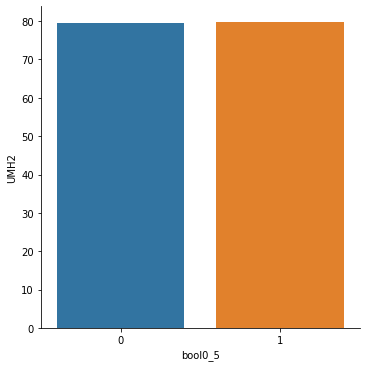

In [29]:
# not huge difference of about 0.266 -> could finish the conclusion by making bootstrap interval -> probably significant
sns.catplot(data=umh.reset_index(),x='bool0_5',y='UMH2',kind='bar')

**PS with `NLESSONS` as treatment**

In [30]:
# logistic regression for NLESSONS
predictors= ['SEX','UREGION','UFAMSTR','UMH2','UMHIGDEG','UAGG','UHHCOUNT','U_SOCPOV','MNBEDRMS',
             'MOWNRENT','OVERCROWDING','BDISBL','BHLTHN','CSPECED','UHINS4']
df_lessons = df_NN(fc23,'NLESSONS',predictors)

log_model_L = 'NLESSONS ~ SEX + UREGION + UFAMSTR + UMH2 + UMHIGDEG + UAGG + \
+ UHHCOUNT + U_SOCPOV + MNBEDRMS + MOWNRENT + OVERCROWDING + BDISBL + BHLTHN + CSPECED + UHINS4'

log_L = smf.logit(formula=log_model_L, data=df_lessons)
res_L = log_L.fit()
res_L.summary()

Optimization terminated successfully.
         Current function value: 0.599141
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               NLESSONS   No. Observations:                21287
Model:                          Logit   Df Residuals:                    21269
Method:                           MLE   Df Model:                           17
Date:                Sat, 05 Dec 2020   Pseudo R-squ.:                 0.06196
Time:                        00:43:42   Log-Likelihood:                -12754.
converged:                       True   LL-Null:                       -13596.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -3.1477      0.225    -13.981      0.000      -3.589      -2.706
UREGION[T.2]    -0.2651      0.043     -6.207      0.000      -0.349      -0.181
UREGION[T.3]    -0.3916      0.044     -8.822      0.000      -0.479      -0.305
UREGION[T.4]    -0.2103      0.045     -4.701      0.000      -0.298      -0.123
SEX              0.7457      0.031     24.405      0.000       0.686       0.806
UFAMSTR          0.1246      0.018      6.930      0.000       0.089       0.160
UMH2             0.0045      0.001      3.535      0.000       0.002       0.007
UMHIGDEG         0.1017      0.008     12.236      0.000       0.085       0.118
UAGG             0.0103      0.009      1.146      0.252      -0.007       0.028
UHHCOUNT        -0.0837      0.024     -3.427      0.001      -0.132      -0.036
U_SOCPOV         0.1702      0.016     10.325      0.000       0.138       0.203
MNBEDRMS         0.1340      0.033      4.015      0.000       0.069       0.199
MOWNRENT         0.0611      0.036      1.678      0.093      -0.010       0.133
OVERCROWDING    -0.0101      0.064     -0.159      0.874      -0.135       0.114
BDISBL           0.1553      0.060      2.608      0.009       0.039       0.272
BHLTHN          -0.1023      0.019     -5.432      0.000      -0.139      -0.065
CSPECED          0.1762      0.058      3.051      0.002       0.063       0.289
UHINS4          -0.0647      0.019     -3.478      0.001      -0.101      -0.028
================================================================================
"""

In [31]:
pred_L = res_L.predict(df_lessons)
diff_L = (pred_L - df_lessons['NLESSONS'])
df_lessons.loc[:,'PS'] = pred_L
print('RES_L :  mean error : '+ str(diff_L.mean())+',  std : '+ str(diff_L.std()))

RES_L :  mean error : -4.7286311141842355e-17,  std : 0.453282614461513


C:\Users\alanh\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\alanh\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


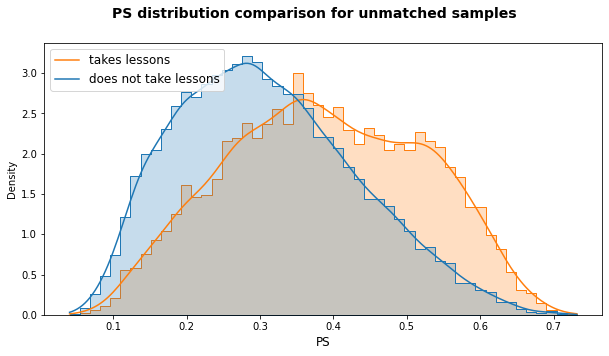

In [32]:
# Plot PS for unmatched groups
fig = plt.figure(figsize=(10,5))
sns.histplot(data=df_lessons, x="PS", hue='NLESSONS', kde=True, element='step', stat='density',
             common_norm=False)
plt.xlabel('PS', fontsize=12)
plt.suptitle('PS distribution comparison for unmatched samples', fontsize=14, fontweight='bold')
plt.legend(['takes lessons','does not take lessons'], loc='upper left', fontsize = 12)
plt.show()

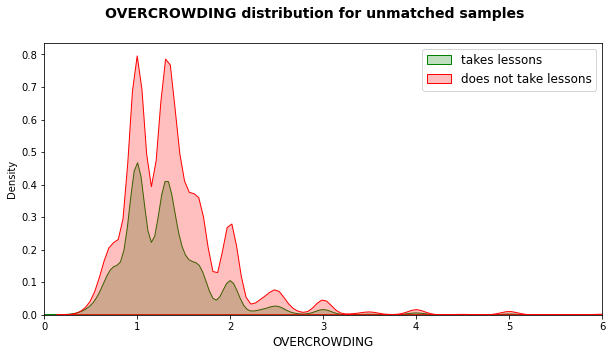

In [33]:
# Plot a seemingly unrelated variable (here OVERCROWDING) for unmatched groups
var = 'OVERCROWDING'
fig = plt.figure(figsize=(10,5))
sns.kdeplot(data=df_lessons, x=var, hue='NLESSONS', palette=['r','g'], shade=True)
plt.xlim(0,6)
plt.xlabel(var, fontsize=12)
plt.suptitle(var+' distribution for unmatched samples', fontsize=14, fontweight='bold')
plt.legend(['takes lessons','does not take lessons'], loc='upper right', fontsize = 12)
plt.show()

In [34]:
eng = df_lessons.groupby('NLESSONS').mean()
eng
print('Diff of mean = ' +str(eng['UENGPOS'][1] - eng['UENGPOS'][0]))

Diff of mean = 0.1037068124418421


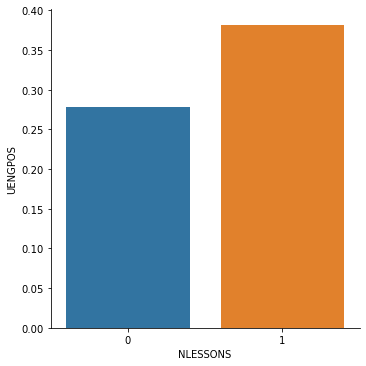

In [35]:
sns.catplot(data=eng.reset_index(),x='NLESSONS',y='UENGPOS',kind='bar')

In [36]:
# Perform matching
trtm_L = df_lessons[df_lessons.NLESSONS == 1].sample(frac=1).reset_index(drop=True)
ctrl_L = df_lessons[df_lessons.NLESSONS == 0].sample(frac=1).reset_index(drop=True)

# Perform matching between treated and non-treated papers
epsilon=0.01
tr_match_idx_L, ctl_match_idx_L = caliper_matching(trtm_L,ctrl_L,epsilon)

print(f'Number of treated subjects (lessons) : {trtm_L.shape[0]} \n\
Number of control subjects (no lessons) : {ctrl_L.shape[0]} \n\
Number of matched pairs : {len(tr_match_idx_L)}')

matched_L = trtm_L.loc[tr_match_idx_L,:].append(ctrl_L.loc[ctl_match_idx_L,:])

Number of treated subjects (lessons) : 7164 
Number of control subjects (no lessons) : 14123 
Number of matched pairs : 6637


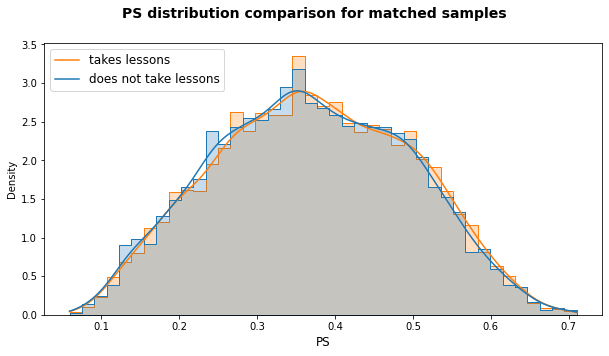

In [37]:
# Plot PS for matched groups
fig = plt.figure(figsize=(10,5))
sns.histplot(data=matched_L, x="PS", hue='NLESSONS', kde=True, element='step', stat='density', 
             common_norm=False)
plt.xlabel('PS', fontsize=12)
plt.suptitle('PS distribution comparison for matched samples', fontsize=14, fontweight='bold')
plt.legend(['takes lessons','does not take lessons'], loc='upper left', fontsize = 12)
plt.show()

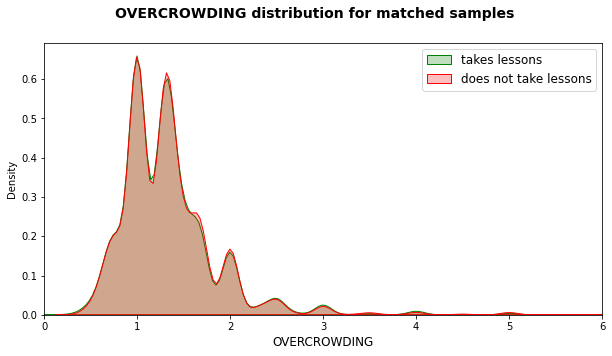

In [38]:
# Plot a seemingly unrelated variable (here OVERCROWDING) for matched groups
var = 'OVERCROWDING'
fig = plt.figure(figsize=(10,5))
sns.kdeplot(data=matched_L, x=var, hue='NLESSONS', palette=['r','g'], shade=True)
plt.xlim(0, 6)
plt.xlabel(var, fontsize=12)
plt.suptitle(var+' distribution for matched samples', fontsize=14, fontweight='bold')
plt.legend(['takes lessons','does not take lessons'], loc='upper right', fontsize = 12)
plt.show()

In [39]:
eng = matched_L.groupby('NLESSONS').mean()
print('Diff of mean = ' +str(eng['UENGPOS'][1] - eng['UENGPOS'][0]))

Diff of mean = 0.039777007684194676


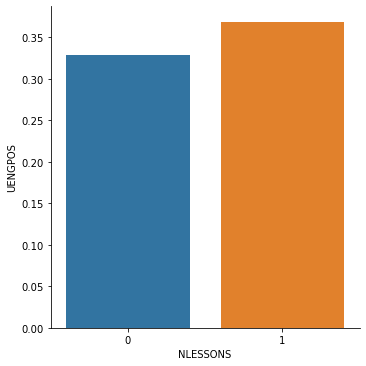

In [40]:
sns.catplot(data=eng.reset_index(),x='NLESSONS',y='UENGPOS',kind='bar')

**PS with `PRECARIOUS` as treatment**

In [41]:
# logistic regression for NLESSONS
predictors= ['SEX','UAGE','UREGION','UENG','UMHIGDEG','UHHCOUNT','MNBEDRMS',
             'OVERCROWDING','BDISBL','CSPECED','UACT','UBPIA','BHLTHN','CSPECED','UHINS4']
df_prec = df_NN(fc2_prec,'precarious',predictors)

log_model_prec = 'precarious ~ SEX + UAGE + UREGION + UENG + UMHIGDEG\
+ UHHCOUNT + MNBEDRMS + OVERCROWDING + BDISBL + CSPECED + UACT + UBPIA + BHLTHN + CSPECED + UHINS4'

log_prec = smf.logit(formula=log_model_prec, data=df_prec)
res_prec = log_prec.fit()
res_prec.summary()

Optimization terminated successfully.
         Current function value: 0.363272
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             precarious   No. Observations:                10434
Model:                          Logit   Df Residuals:                    10417
Method:                           MLE   Df Model:                           16
Date:                Sat, 05 Dec 2020   Pseudo R-squ.:                  0.3150
Time:                        00:49:56   Log-Likelihood:                -3790.4
converged:                       True   LL-Null:                       -5533.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.4655      0.384      3.814      0.000       0.712       2.219
UREGION[T.2]    -0.3872      0.087     -4.427      0.000      -0.559      -0.216
UREGION[T.3]    -0.1139      0.083     -1.378      0.168      -0.276       0.048
UREGION[T.4]    -0.2478      0.087     -2.854      0.004      -0.418      -0.078
SEX              0.1120      0.060      1.879      0.060      -0.005       0.229
UAGE             0.0392      0.017      2.245      0.025       0.005       0.073
UENG            -0.0570      0.013     -4.507      0.000      -0.082      -0.032
UMHIGDEG        -0.0248      0.015     -1.650      0.099      -0.054       0.005
UHHCOUNT        -0.0486      0.046     -1.051      0.293      -0.139       0.042
MNBEDRMS        -0.6637      0.076     -8.693      0.000      -0.813      -0.514
OVERCROWDING     0.2158      0.106      2.041      0.041       0.009       0.423
BDISBL          -0.2346      0.101     -2.334      0.020      -0.432      -0.038
CSPECED         -0.0748      0.092     -0.812      0.417      -0.255       0.106
UACT            -0.4263      0.033    -12.777      0.000      -0.492      -0.361
UBPIA           -0.1001      0.015     -6.482      0.000      -0.130      -0.070
BHLTHN           0.2114      0.032      6.564      0.000       0.148       0.274
UHINS4           1.1827      0.032     36.637      0.000       1.119       1.246
================================================================================
"""

In [42]:
pred_prec = res_prec.predict(df_prec)
diff_prec = (pred_prec - df_prec['precarious'])
df_prec.loc[:,'PS'] = pred_prec
print('RES_prec :  mean error : '+ str(diff_prec.mean())+',  std : '+ str(diff_prec.std()))

RES_prec :  mean error : 3.30864337269688e-17,  std : 0.340241073254943


C:\Users\alanh\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\alanh\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


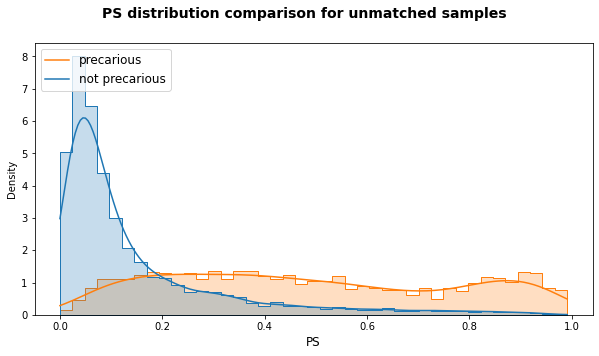

In [43]:
# Plot PS for unmatched groups
fig = plt.figure(figsize=(10,5))
sns.histplot(data=df_prec, x="PS", hue='precarious', kde=True, element='step', stat='density',
             common_norm=False)
plt.xlabel('PS', fontsize=12)
plt.suptitle('PS distribution comparison for unmatched samples', fontsize=14, fontweight='bold')
plt.legend(['precarious','not precarious'], loc='upper left', fontsize = 12)
plt.show()

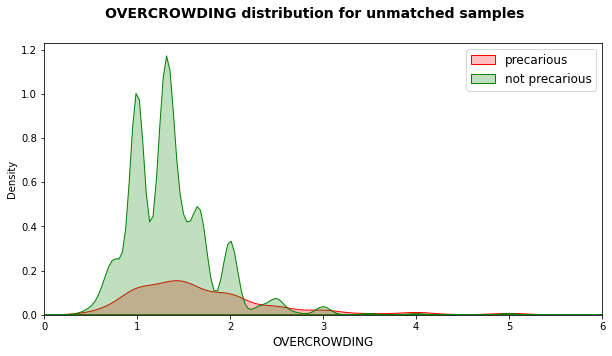

In [44]:
# Plot a seemingly unrelated variable (here OVERCROWDING) for unmatched groups
var = 'OVERCROWDING'
fig = plt.figure(figsize=(10,5))
sns.kdeplot(data=df_prec, x=var, hue='precarious', palette=['g','r'], shade=True)
plt.xlim(0,6)
plt.xlabel(var, fontsize=12)
plt.suptitle(var+' distribution for unmatched samples', fontsize=14, fontweight='bold')
plt.legend(['precarious','not precarious'], loc='upper right', fontsize = 12)
plt.show()

In [45]:
eng = df_prec.groupby('precarious').mean()
eng
print('Diff of mean = ' +str(eng['UENGPOS'][0] - eng['UENGPOS'][1]))
# on peut print plusieurs diff of means pour des bails différents ()

Diff of mean = 0.10374370478213718


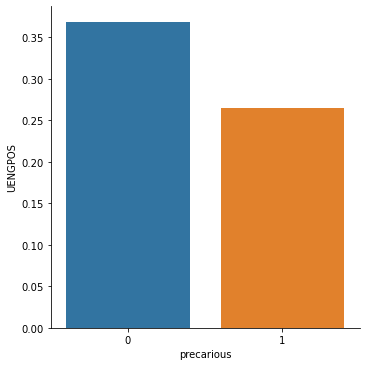

In [46]:
sns.catplot(data=eng.reset_index(),x='precarious',y='UENGPOS',kind='bar')

In [47]:
# Perform matching
trtm_prec = df_prec[df_prec.precarious == 1].sample(frac=1).reset_index(drop=True)
ctrl_prec = df_prec[df_prec.precarious == 0].sample(frac=1).reset_index(drop=True)

# Perform matching between treated and non-treated papers
epsilon=0.05
tr_match_idx_prec, ctl_match_idx_prec = caliper_matching(trtm_prec,ctrl_prec,epsilon)

print(f'Number of treated subjects (precarious) : {trtm_prec.shape[0]} \n\
Number of control subjects (not precarious) : {ctrl_prec.shape[0]} \n\
Number of matched pairs : {len(tr_match_idx_prec)}')

matched_prec = trtm_prec.loc[tr_match_idx_prec,:].append(ctrl_prec.loc[ctl_match_idx_prec,:])

Number of treated subjects (precarious) : 2324 
Number of control subjects (not precarious) : 8110 
Number of matched pairs : 1832


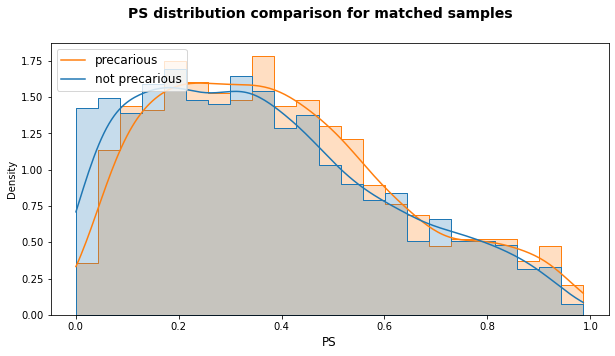

In [48]:
# Plot PS for matched groups
fig = plt.figure(figsize=(10,5))
sns.histplot(data=matched_prec, x="PS", hue='precarious', kde=True, element='step', stat='density', 
             common_norm=False)
plt.xlabel('PS', fontsize=12)
plt.suptitle('PS distribution comparison for matched samples', fontsize=14, fontweight='bold')
plt.legend(['precarious','not precarious'], loc='upper right', fontsize = 12)
plt.show()

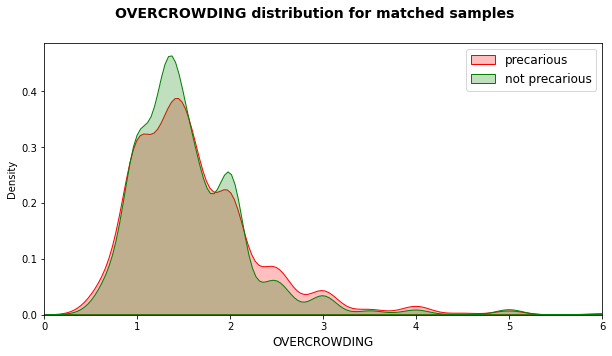

In [49]:
# Plot a seemingly unrelated variable (here OVERCROWDING) for matched groups
var = 'OVERCROWDING'
fig = plt.figure(figsize=(10,5))
sns.kdeplot(data=matched_prec, x=var, hue='precarious', palette=['g','r'], shade=True)
plt.xlim(0, 6)
plt.xlabel(var, fontsize=12)
plt.suptitle(var+' distribution for matched samples', fontsize=14, fontweight='bold')
plt.legend(['precarious','not precarious'], loc='upper right', fontsize = 12)
plt.show()

In [50]:
eng = matched_prec.groupby('precarious').mean()
print('Diff of mean = ' +str(eng['UENGPOS'][0] - eng['UENGPOS'][1]))

Diff of mean = -0.009279475982532759


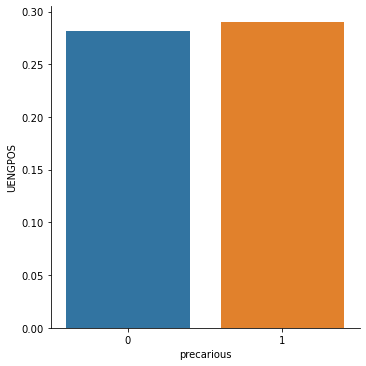

In [51]:
sns.catplot(data=eng.reset_index(),x='precarious',y='UENGPOS',kind='bar')

## Linear regression models

In [52]:
# returns a regression of the 'predictors' on the 'outcome', using only subjects in 'df' that answered
# to all the outcome and predictor questions
def res_NN(df,outcome,predictors):
    
    # df without rows containing NaNs for the outcome & predictors
    df_reg = df_NN(df,outcome,predictors)
    
    # model description
    model = outcome+' ~ '
    for i in range (0,len(predictors)):
        model = model+predictors[i]
        if i != len(predictors)-1 :    # if not last
            model = model+'+'
    
    # model fit, cluster std based on state        
    return smf.ols(formula=model, data=df_reg).fit(cov_type='cluster',cov_kwds={'groups': df_reg['STATE']})

## Education

In [53]:
outcome = 'UENG'
predictors = family+income+housing_hh+['SEX','UAGE','UACT','CSPECED']
res = res_NN(fc23,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   UENG   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     1385.
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           1.19e-58
Time:                        00:52:50   Log-Likelihood:                -48861.
No. Observations:               21077   AIC:                         9.775e+04
Df Residuals:                   21064   BIC:                         9.785e+04
Df Model:                          12                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.0595      0.276     18.324   

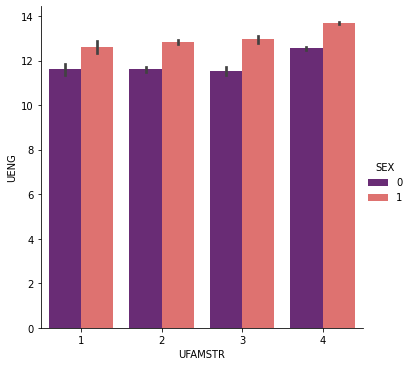

In [54]:
sns.catplot(y='UENG', x='UFAMSTR', hue='SEX', kind='bar', palette='magma', data=df_NN(fc23,outcome,predictors))

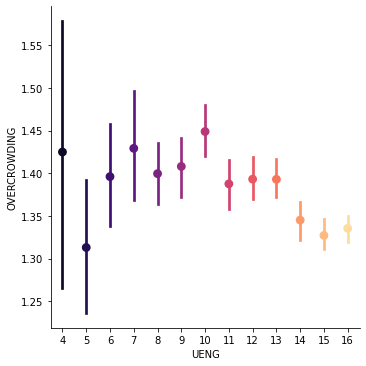

In [55]:
sns.catplot(x='UENG', y='OVERCROWDING',kind='point', palette='magma', data=df_NN(fc23,outcome,predictors))

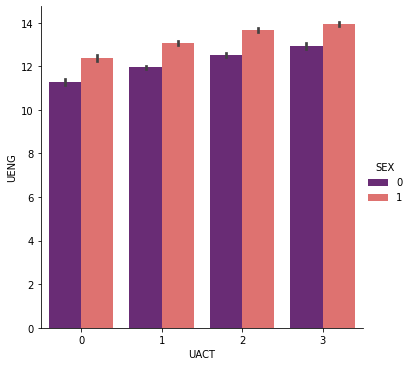

In [56]:
sns.catplot(y='UENG', x='UACT', hue='SEX', kind='bar', palette='magma', data=df_NN(fc23,outcome,predictors))

## Health

In [57]:
outcome = 'BHLTHN'
predictors = family+income+housing_hh+['SEX','UAGE','UACT']
res = res_NN(fc23,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 BHLTHN   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     258.4
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           4.85e-40
Time:                        00:52:53   Log-Likelihood:                -26914.
No. Observations:               21461   AIC:                         5.385e+04
Df Residuals:                   21449   BIC:                         5.395e+04
Df Model:                          11                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.2293      0.086     37.575   

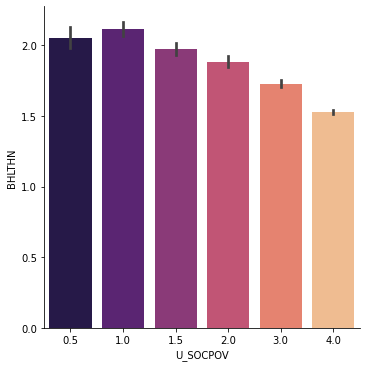

In [58]:
sns.catplot(y='BHLTHN', x='U_SOCPOV',kind='bar',palette='magma', data=df_NN(fc23,outcome,predictors))

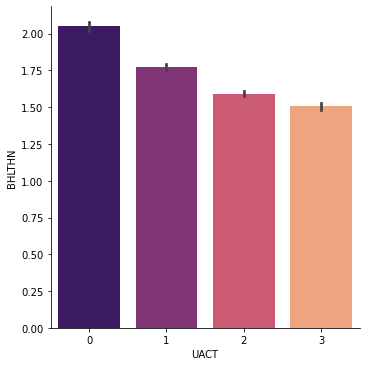

In [59]:
sns.catplot(y='BHLTHN', x='UACT',kind='bar', palette='magma', data=df_NN(fc23,outcome,predictors))

## Mental health


**fc2**


In [60]:
outcome = 'UBPIA'
predictors = family+income+housing_hh+['SEX','UAGE','UACT']
res = res_NN(fc2,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  UBPIA   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     598.6
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           4.88e-49
Time:                        00:52:54   Log-Likelihood:                -21285.
No. Observations:               10583   AIC:                         4.259e+04
Df Residuals:                   10571   BIC:                         4.268e+04
Df Model:                          11                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        7.7844      0.220     35.364   

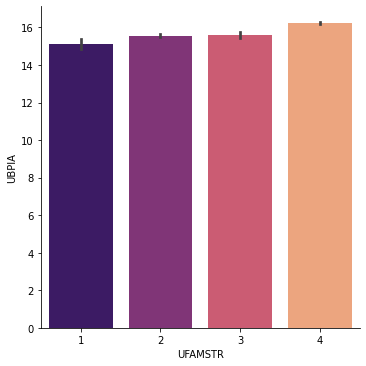

In [61]:
sns.catplot(y='UBPIA', x='UFAMSTR', kind='bar', palette='magma', data=df_NN(fc2,outcome,predictors))

**fc3**

In [62]:
outcome = 'UBPIB'
predictors = family+income+housing_hh+['SEX','UAGE','UACT']
res = res_NN(fc3,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  UBPIB   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     668.4
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           3.16e-50
Time:                        00:52:55   Log-Likelihood:                -21992.
No. Observations:               10784   AIC:                         4.401e+04
Df Residuals:                   10772   BIC:                         4.410e+04
Df Model:                          11                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.7996      0.329     17.615   

In [63]:
df_noNull = df_NN(fc3,outcome, predictors)
xtest = df_noNull[predictors]
diff = (res.predict(xtest) - df_noNull['UBPIB'])
print(diff.mean(),diff.std())
#error is normally distributed -> good, but the low r squared gives a rather high std

-6.4020664799823936e-15 1.859725625210495


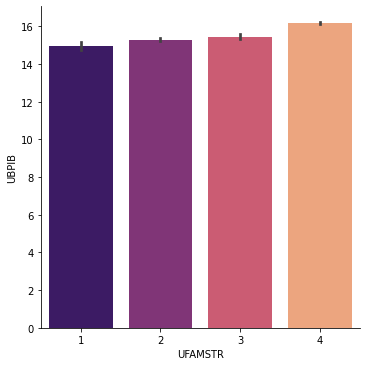

In [64]:
sns.catplot(y='UBPIB', x='UFAMSTR', kind='bar', palette='magma', data=df_NN(fc3,outcome,predictors))

## Conclusion Q1

Looking at the whole model, we can say that mental health is most influenced by housing conditions.

## Mental health of UMH2

In [65]:
outcome = 'UMH2'
predictors = family_hh+income+housing_hh
res = res_NN(child,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   UMH2   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     44.53
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           2.55e-19
Time:                        00:52:56   Log-Likelihood:            -1.3349e+05
No. Observations:               33553   AIC:                         2.670e+05
Df Residuals:                   33545   BIC:                         2.671e+05
Df Model:                           7                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       72.4220      0.783     92.483   

In [66]:
outcome = 'UENGNEG'
predictors = ['UFAMSTR']
df_noNull = df_NN(fc23,outcome, predictors)

<AxesSubplot:xlabel='UFAMSTR', ylabel='Probability'>

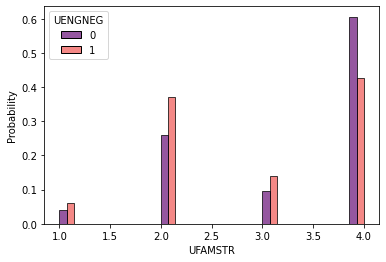

In [67]:
sns.histplot(x='UFAMSTR', hue='UENGNEG', stat='probability', data=df_noNull, common_norm=False,
             multiple='dodge', palette='magma')
# dans quelles familles sont distribués les gars mauvais